<a href="https://colab.research.google.com/github/thevinudassanayake/ML-Cousework-telco-churn-project-/blob/main/Emotion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_ROOT = "/content/drive/MyDrive/Dataset"


In [ ]:
import os
os.listdir(DATASET_ROOT)


['0001.parquet', '0000.parquet', '0002.parquet']

In [ ]:
print("Files found:")
for f in os.listdir(DATASET_ROOT)[:10]:
    print(f)


Files found:
0001.parquet
0000.parquet
0002.parquet


In [ ]:
print("Sample label_dict key:", list(label_dict.keys())[0])


Sample label_dict key: sample1.wav


In [ ]:
import os
import io
import numpy as np
import pandas as pd
import librosa
import soundfile as sf


PARQUET_FOLDER = "/content/drive/MyDrive/Dataset"
SAVE_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"
os.makedirs(SAVE_FOLDER, exist_ok=True)

X_PATH = os.path.join(SAVE_FOLDER, "X_seq.npy")
Y_PATH = os.path.join(SAVE_FOLDER, "Y_seq.npy")


SR = 16000
FRAME_MS = 0.025
HOP_MS = 0.010
N_FFT = int(SR * FRAME_MS)
HOP_LENGTH = int(SR * HOP_MS)
N_MFCC = 40


SEQ_LEN = 300

EMOTION_COLS = ['frustrated', 'angry', 'sad', 'disgust', 'excited',
                'fear', 'neutral', 'surprise', 'happy']


def normalize_audio(audio):
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val
    return audio

def audio_from_bytes(audio_dict):
    audio_bytes = audio_dict['bytes']
    audio_array, sr = sf.read(io.BytesIO(audio_bytes))
    if sr != SR:
        audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=SR)
    return audio_array

def process_row(row):
    """
    Takes one row (one file) and slices it into multiple 3-second chunks.
    """

    audio = audio_from_bytes(row['audio'])
    audio = normalize_audio(audio)

    mfcc = librosa.feature.mfcc(
        y=audio, sr=SR, n_mfcc=N_MFCC, n_fft=N_FFT,
        hop_length=HOP_LENGTH, window='hamming'
    ).T


    file_label = row[EMOTION_COLS].to_numpy(dtype=np.float32)



    num_frames = mfcc.shape[0]
    chunks_X = []
    chunks_Y = []


    step = 150

    for start in range(0, num_frames - SEQ_LEN + 1, step):
        end = start + SEQ_LEN


        chunk = mfcc[start:end, :]

        chunks_X.append(chunk)
        chunks_Y.append(file_label)

    return chunks_X, chunks_Y

X_all = []
Y_all = []

print("Starting Sequence Preprocessing...")

parquet_files = [f for f in os.listdir(PARQUET_FOLDER) if f.lower().endswith(".parquet")]
for pq_file in parquet_files:
    pq_path = os.path.join(PARQUET_FOLDER, pq_file)
    df = pd.read_parquet(pq_path)

    print(f"Processing {pq_file}...")

    for _, row in df.iterrows():
        new_X_chunks, new_Y_chunks = process_row(row)


        if len(new_X_chunks) > 0:
            X_all.extend(new_X_chunks)
            Y_all.extend(new_Y_chunks)

if len(X_all) == 0:
    print("Error: No data processed. Check if audio files are shorter than 3 seconds.")
else:

    X_final = np.array(X_all)
    Y_final = np.array(Y_all)

    print("Finished!")
    print(f"X Shape: {X_final.shape} (Chunks, Time, Features)")
    print(f"Y Shape: {Y_final.shape} (Chunks, Classes)")

    np.save(X_PATH, X_final)
    np.save(Y_PATH, Y_final)
    print(f"Saved to {SAVE_FOLDER}")

Starting Sequence Preprocessing...
Processing 0000.parquet...
Processing 0001.parquet...
Processing 0002.parquet...
Finished!
X Shape: (15498, 300, 40) (Chunks, Time, Features)
Y Shape: (15498, 9) (Chunks, Classes)
Saved to /content/drive/MyDrive/Processed_Data_Seq


In [ ]:
import numpy as np
import os


DATA_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"

X_PATH = os.path.join(DATA_FOLDER, "X_seq.npy")
Y_PATH = os.path.join(DATA_FOLDER, "Y_seq.npy")

print(f"Reading files from: {DATA_FOLDER} ...\n")

if os.path.exists(X_PATH) and os.path.exists(Y_PATH):
    X_loaded = np.load(X_PATH)
    Y_loaded = np.load(Y_PATH)


    print(f"SUCCESS! Files Loaded.")
    print(f"X File (Input Audio): {X_loaded.shape}  <-- (Total Chunks, 300 Time Steps, 40 Features)")
    print(f"Y File (Labels):      {Y_loaded.shape}      <-- (Total Chunks, 9 Emotion Classes)")
    print("-" * 60)



    print("\n--- SAMPLE CHECK: CHUNK #0 ---\n")

    print("Y DATA (The Label for Chunk 0):")
    print(Y_loaded[0])
    print("(This is the probability list for: Fru, Ang, Sad, Dis, Exc, Fea, Neu, Sur, Hap)")

    print("\n" + "-"*30 + "\n")

    print("X DATA (The Audio Features for Chunk 0):")
    print("Time Step 0 (Start):", X_loaded[0][0][:5], "... (35 more numbers)")
    print("Time Step 1 (Next): ", X_loaded[0][1][:5], "... (35 more numbers)")
    print("...")
    print("Time Step 299 (End):", X_loaded[0][299][:5], "... (35 more numbers)")

else:
    print("ERROR: Files not found. Did you run the previous processing block?")

Reading files from: /content/drive/MyDrive/Processed_Data_Seq ...

SUCCESS! Files Loaded.
X File (Input Audio): (15498, 300, 40)  <-- (Total Chunks, 300 Time Steps, 40 Features)
Y File (Labels):      (15498, 9)      <-- (Total Chunks, 9 Emotion Classes)
------------------------------------------------------------

--- SAMPLE CHECK: CHUNK #0 ---

Y DATA (The Label for Chunk 0):
[0.00625 0.195   0.00625 0.00625 0.00625 0.00625 0.5725  0.195   0.00625]
(This is the probability list for: Fru, Ang, Sad, Dis, Exc, Fea, Neu, Sur, Hap)

------------------------------

X DATA (The Audio Features for Chunk 0):
Time Step 0 (Start): [-505.60872613  136.97407072    7.9306188    25.06150545    9.14306498] ... (35 more numbers)
Time Step 1 (Next):  [-489.06492761  123.60532447   -3.39033951   27.31571376   -1.13075758] ... (35 more numbers)
...
Time Step 299 (End): [-476.1711438   127.31100013   -2.34779073   20.79190087   -2.92018015] ... (35 more numbers)


Loading /content/drive/MyDrive/Processed_Data_Seq/Y_seq.npy...

EMOTION         | COUNT      | PERCENTAGE
Frustrated      | 5058       | 32.6%
Angry           | 1876       | 12.1%
Sad             | 2648       | 17.1%
Disgust         | 18         | 0.1%
Excited         | 2776       | 17.9%
Fear            | 36         | 0.2%
Neutral         | 2070       | 13.4%
Surprise        | 78         | 0.5%
Happy           | 938        | 6.1%
---------------------------------------------
TOTAL           | 15498      | 100%



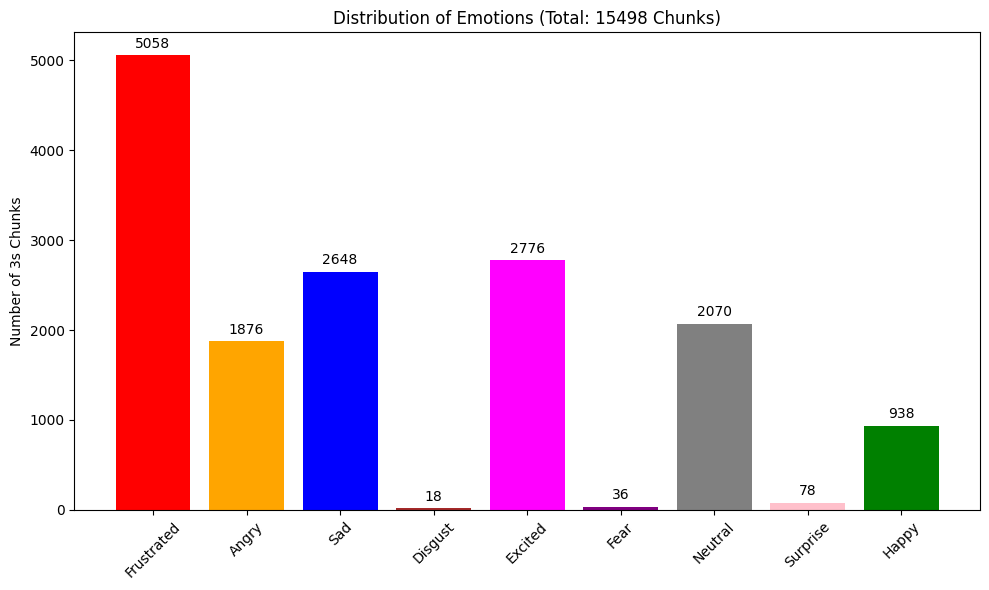

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt


DATA_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"
Y_PATH = os.path.join(DATA_FOLDER, "Y_seq.npy")

EMOTIONS = ['Frustrated', 'Angry', 'Sad', 'Disgust', 'Excited',
            'Fear', 'Neutral', 'Surprise', 'Happy']

print(f"Loading {Y_PATH}...")
Y_raw = np.load(Y_PATH)


winners = np.argmax(Y_raw, axis=1)

counts = [0] * 9
for idx in winners:
    counts[idx] += 1

total_files = len(Y_raw)

print("\n" + "="*45)
print(f"{'EMOTION':<15} | {'COUNT':<10} | {'PERCENTAGE':<10}")
print("="*45)

for i, count in enumerate(counts):
    percent = (count / total_files) * 100
    print(f"{EMOTIONS[i]:<15} | {count:<10} | {percent:.1f}%")

print("-" * 45)
print(f"{'TOTAL':<15} | {total_files:<10} | 100%")
print("="*45 + "\n")


plt.figure(figsize=(10, 6))
bars = plt.bar(EMOTIONS, counts, color=['red', 'orange', 'blue', 'brown', 'magenta', 'purple', 'gray', 'pink', 'green'])


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom')

plt.title(f"Distribution of Emotions (Total: {total_files} Chunks)")
plt.ylabel("Number of 3s Chunks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import os


DATA_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"

print("Loading raw data...")
X_raw = np.load(os.path.join(DATA_FOLDER, "X_seq.npy"))
Y_raw = np.load(os.path.join(DATA_FOLDER, "Y_seq.npy"))

print(f"Original Count: {len(X_raw)} chunks")


MAPPING = {
    0: -1,  # Frustrated (5058) -> DELETE (Too dominant/confusing)
    1: 0,   # Angry      (1876) -> Keep as Class 0
    2: 1,   # Sad        (2648) -> Keep as Class 1
    3: -1,  # Disgust    (18)   -> DELETE (Too small)
    4: 3,   # Excited    (2776) -> MERGE into Class 3 (Happy)
    5: -1,  # Fear       (36)   -> DELETE (Too small)
    6: 2,   # Neutral    (2070) -> Keep as Class 2
    7: -1,  # Surprise   (78)   -> DELETE (Too small)
    8: 3    # Happy      (938)  -> Keep as Class 3
}

X_clean = []
Y_clean = []

print("Filtering and Merging...")

for i in range(len(Y_raw)):

    old_label = np.argmax(Y_raw[i])


    new_label = MAPPING[old_label]

    if new_label != -1:
        X_clean.append(X_raw[i])
        Y_clean.append(new_label)


X_final = np.array(X_clean)
Y_final = np.array(Y_clean)

print("-" * 30)
print(f"Cleanup Complete!")
print(f"Original Files: {len(X_raw)}")
print(f"Final Files:    {len(X_final)}")
print("-" * 30)


unique, counts = np.unique(Y_final, return_counts=True)
classes = ['Angry', 'Sad', 'Neutral', 'Happy']
print("\nNew Distribution:")
for u, c in zip(unique, counts):
    print(f"{classes[u]}: {c} files")


np.save(os.path.join(DATA_FOLDER, "X_final.npy"), X_final)
np.save(os.path.join(DATA_FOLDER, "Y_final.npy"), Y_final)
print(f"\nSaved 'X_final.npy' and 'Y_final.npy' to {DATA_FOLDER}")

Loading raw data...
Original Count: 15498 chunks
Filtering and Merging...
------------------------------
Cleanup Complete!
Original Files: 15498
Final Files:    10308
------------------------------

New Distribution:
Angry: 1876 files
Sad: 2648 files
Neutral: 2070 files
Happy: 3714 files

Saved 'X_final.npy' and 'Y_final.npy' to /content/drive/MyDrive/Processed_Data_Seq


Loading final files from /content/drive/MyDrive/Processed_Data_Seq...

X Shape (Audio):  (10308, 300, 40)
Y Shape (Labels): (10308,)
----------------------------------------
CLASS ID   | EMOTION    | COUNT      | % OF DATA
--------------------------------------------------
0          | Angry      | 1876       | 18.2%
1          | Sad        | 2648       | 25.7%
2          | Neutral    | 2070       | 20.1%
3          | Happy      | 3714       | 36.0%
--------------------------------------------------
TOTAL                   | 10308     

--- DATA SAMPLE (Row 0) ---
Label: 2 -> 'Neutral'
Audio: [-505.60872613  136.97407072    7.9306188    25.06150545    9.14306498] ... (First 5 numbers)


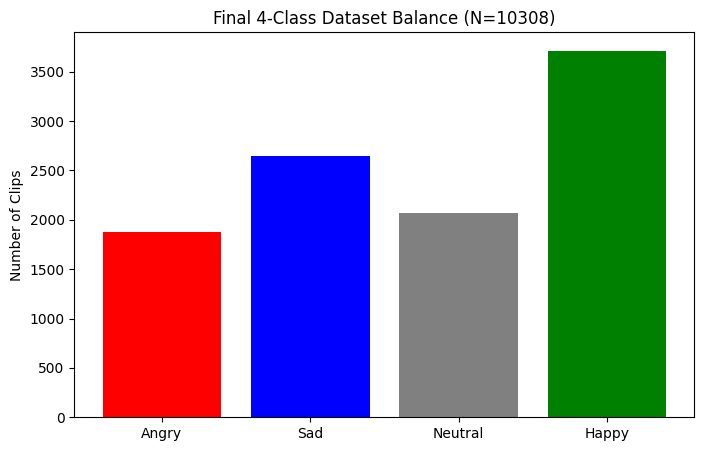

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

DATA_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"
X_PATH = os.path.join(DATA_FOLDER, "X_final.npy")
Y_PATH = os.path.join(DATA_FOLDER, "Y_final.npy")


CLASSES = ['Angry', 'Sad', 'Neutral', 'Happy']

print(f"Loading final files from {DATA_FOLDER}...\n")

if os.path.exists(X_PATH) and os.path.exists(Y_PATH):
    X = np.load(X_PATH)
    Y = np.load(Y_PATH)

    print(f"X Shape (Audio):  {X.shape}")
    print(f"Y Shape (Labels): {Y.shape}")
    print("-" * 40)

    unique, counts = np.unique(Y, return_counts=True)

    print(f"{'CLASS ID':<10} | {'EMOTION':<10} | {'COUNT':<10} | {'% OF DATA'}")
    print("-" * 50)

    total = len(Y)
    for u, c in zip(unique, counts):
        percentage = (c / total) * 100
        print(f"{u:<10} | {CLASSES[u]:<10} | {c:<10} | {percentage:.1f}%")

    print("-" * 50)
    print(f"{'TOTAL':<23} | {total:<10}")


    print("\n--- DATA SAMPLE (Row 0) ---")
    print(f"Label: {Y[0]} -> '{CLASSES[Y[0]]}'")
    print(f"Audio: {X[0][0][:5]} ... (First 5 numbers)")

    plt.figure(figsize=(8, 5))
    plt.bar(CLASSES, counts, color=['red', 'blue', 'gray', 'green'])
    plt.title(f"Final 4-Class Dataset Balance (N={total})")
    plt.ylabel("Number of Clips")
    plt.show()

else:
    print("Error: X_final.npy not found. Did you run the filtering script?")

In [ ]:
import numpy as np
import os

DATA_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"
X_PATH = os.path.join(DATA_FOLDER, "X_final.npy")
Y_PATH = os.path.join(DATA_FOLDER, "Y_final.npy")

CLASSES = ['Angry', 'Sad', 'Neutral', 'Happy']

print(f"Opening files from {DATA_FOLDER}...\n")

X = np.load(X_PATH)
Y = np.load(Y_PATH)


print("--- VISUAL STRUCTURE ---")
print(f"X (Audio Tower):      {X.shape}  (Rows, Time, Features)")
print(f"Y (Label Scoreboard): {Y.shape}      (Rows,)\n")

print(f"{'INDEX':<8} | {'Y VALUE':<10} | {'MEANING':<10} | {'X DATA SNAPSHOT (First 3 nums)'}")
print("-" * 75)

for i in range(15):

    label_id = Y[i]
    label_name = CLASSES[label_id]


    raw_nums = X[i][0][:3]
    data_str = f"[{raw_nums[0]:.1f}, {raw_nums[1]:.1f}, {raw_nums[2]:.1f}]"

    print(f"{i:<8} | {label_id:<10} | {label_name:<10} | {data_str}")

print("-" * 75)

Opening files from /content/drive/MyDrive/Processed_Data_Seq...

--- VISUAL STRUCTURE ---
X (Audio Tower):      (10308, 300, 40)  (Rows, Time, Features)
Y (Label Scoreboard): (10308,)      (Rows,)

INDEX    | Y VALUE    | MEANING    | X DATA SNAPSHOT (First 3 nums)
---------------------------------------------------------------------------
0        | 2          | Neutral    | [-505.6, 137.0, 7.9]
1        | 2          | Neutral    | [-616.0, 86.7, 25.8]
2        | 0          | Angry      | [-481.7, 63.9, -16.7]
3        | 0          | Angry      | [-364.9, 130.2, -4.2]
4        | 0          | Angry      | [-413.5, 125.2, -11.3]
5        | 0          | Angry      | [-487.3, 98.2, -32.8]
6        | 0          | Angry      | [-227.6, 125.5, -25.1]
7        | 0          | Angry      | [-435.6, 103.0, -36.7]
8        | 1          | Sad        | [-407.2, 93.5, -7.6]
9        | 1          | Sad        | [-329.2, 143.9, 19.6]
10       | 1          | Sad        | [-392.9, 110.9, -1.0]
11       

In [ ]:
import numpy as np
import os

DATA_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"
X_PATH = os.path.join(DATA_FOLDER, "X_final.npy")
Y_PATH = os.path.join(DATA_FOLDER, "Y_final.npy")

CLASSES = ['Angry', 'Sad', 'Neutral', 'Happy']


X = np.load(X_PATH)
Y = np.load(Y_PATH)

print(f"X Shape: {X.shape}")
print(f"Y Shape: {Y.shape}")
print("\n" + "="*60)

for i in range(5):

    label_id = Y[i]
    label_name = CLASSES[label_id]

    print(f"FLOOR {i}  |  Label: {label_id} ({label_name})")
    print("-" * 60)


    ts1 = np.round(X[i][0], 2)
    print(f"  Time Step 1: {ts1[:10]} ... (showing 10/40 features)")


    ts2 = np.round(X[i][1], 2)
    print(f"  Time Step 2: {ts2[:10]} ... (showing 10/40 features)")

    print("="*60 + "\n")

X Shape: (10308, 300, 40)
Y Shape: (10308,)

FLOOR 0  |  Label: 2 (Neutral)
------------------------------------------------------------
  Time Step 1: [-505.61  136.97    7.93   25.06    9.14   15.89   -5.43    2.54    0.97
   17.31] ... (showing 10/40 features)
  Time Step 2: [-489.06  123.61   -3.39   27.32   -1.13    9.65   -2.49   16.28    7.72
    9.18] ... (showing 10/40 features)

FLOOR 1  |  Label: 2 (Neutral)
------------------------------------------------------------
  Time Step 1: [-6.1601e+02  8.6730e+01  2.5810e+01 -3.3400e+00 -2.4000e-01  3.1800e+00
 -1.3100e+00  8.3000e-01  4.0800e+00 -9.3000e-01] ... (showing 10/40 features)
  Time Step 2: [-601.46   96.29   34.24   20.36   26.54   21.99    9.3    12.31   12.71
   -0.68] ... (showing 10/40 features)

FLOOR 2  |  Label: 0 (Angry)
------------------------------------------------------------
  Time Step 1: [-481.72   63.94  -16.68   31.59  -14.15    0.61  -13.29   13.79   -1.59
   16.6 ] ... (showing 10/40 features)
  Ti

In [ ]:
import numpy as np
import os


DATA_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"
Y_PATH = os.path.join(DATA_FOLDER, "Y_final.npy")

CLASSES = ['Angry', 'Sad', 'Neutral', 'Happy']


print(f"Loading labels from {Y_PATH}...\n")
Y = np.load(Y_PATH)

print("="*40)
print(f"{'FLOOR':<8} | {'ID':<5} | {'EMOTION NAME'}")
print("="*40)

for i in range(5):
    class_id = Y[i]
    emotion_name = CLASSES[class_id]

    print(f"{i:<8} | {class_id:<5} | {emotion_name}")

print("-" * 40)

Loading labels from /content/drive/MyDrive/Processed_Data_Seq/Y_final.npy...

FLOOR    | ID    | EMOTION NAME
0        | 2     | Neutral
1        | 2     | Neutral
2        | 0     | Angry
3        | 0     | Angry
4        | 0     | Angry
----------------------------------------


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Bidirectional, Layer, GlobalAveragePooling1D, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K


DATA_FOLDER = "/content/drive/MyDrive/Processed_Data_Seq"
MODEL_SAVE_PATH = "/content/drive/MyDrive/Processed_Data_Seq/emotion_model_attention.keras"
X_PATH = os.path.join(DATA_FOLDER, "X_final.npy")
Y_PATH = os.path.join(DATA_FOLDER, "Y_final.npy")
CLASSES = ['Angry', 'Sad', 'Neutral', 'Happy']

print("Loading data for the 'Attention' run...")
X = np.load(X_PATH)
Y = np.load(Y_PATH)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='normal', trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):

        e = K.tanh(K.dot(x, self.W) + self.b)

        a = K.softmax(e, axis=1)

        output = x * a

        return K.sum(output, axis=1)

inputs = Input(shape=(300, 40))


x = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)


x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)


x = Attention()(x)


x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


optim = Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

print("\nStarting High-Intensity Training (15 Epochs)...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    callbacks=[checkpoint, lr_reducer],
    verbose=1
)


print("\n" + "="*40)
print("FINAL RESULTS (Attention Model)")
print("="*40)


model.load_weights(MODEL_SAVE_PATH)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Best Test Accuracy: {accuracy*100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred_classes, target_names=CLASSES))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


print("Generating predictions...")
y_pred_raw = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_raw, axis=1)


cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)

plt.title('Emotion Classification Heatmap')
plt.ylabel('TRUE EMOTION (What it actually is)')
plt.xlabel('PREDICTED EMOTION (What the model guessed)')
plt.show()